# 3 layered LSTM regularized/unregularized
# Natural language processing model on PennTreeBank dataset

This notebook contains and tests two 3 layered LSTM models; one regularized and one unregularized. 

## Experiment
The goal of this notebook is to test and benchmark two 3 layered LSTM models and is part of a larger goal to generate proteins by using a [Conditional Transformer Language model](https://einstein.ai/presentations/ctrl.pdf).

The model giving the best results can be found here (insert link).

The model accuracy is evaluated in bits per character (BPC), which is a  metric  used  to  describes  theaverage number of bits needed to encode on a character. Accuracy of character-level language models are typically reported in BPC.


## Pretrained weights for the model
Pretrained weights for the model can be found in the [here](https://drive.google.com/open?id=19vBZTCBuMbjjYgclTQPA_jlOcTKXK0e5). The save weight for the model is:
* pretrained_char_model_layed_lstm_with_dropout.pkl
  * with dropout and weight decay
* pretrained_char_model_layed_lstm_unregularized_100.pkl


## Referances
* Pytorch for Deep Learning with Python Bootcamp, with Jose Portilla - udemy.com
* Deel Learning 02456 week 5 exercises: 5.1-EXE-Recurrent-Neural-Networks.ipynb
* TorchText: https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
* paper on DPR regularization: https://arxiv.org/pdf/1808.05908v4.pdf
* tutorial in RNN: https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=xPVERl79rCYW
* papers with code: https://paperswithcode.com/paper/improved-language-modeling-by-decoding-the
* trellisnet github: https://github.com/locuslab/trellisnet/tree/master/TrellisNet/char_PTB
* Language modeling tutorial in torch: https://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/
* On saving/loading models: https://pytorch.org/tutorials/beginner/saving_loading_models.html
* awd-lstm github: https://github.com/salesforce/awd-lstm-lm
* RNN training tips: https://towardsdatascience.com/rnn-training-tips-and-tricks-2bf687e67527


## Tips
When running the notebook in colab, insert following javascript code into the console to precent colab from disconnecting after 30min, due to inactivity.

> `function ClickConnect(){
 console.log("Working"); 
 document.querySelector("colab-toolbar-button#connect").click() 
 }
 setInterval(ClickConnect,60000)`






## Importing needed libraries

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
import torch

## Check GPU availabiliy

In [74]:
print(torch.cuda.device_count()) # how many devices available
print(torch.cuda.get_device_name(torch.cuda.current_device())) # which device currently in use
print(torch.cuda.get_device_capability()) # get the cuda compute capability
print(torch.cuda.get_device_properties(torch.cuda.current_device()))
!nvidia-smi

1
Tesla P100-PCIE-16GB
(6, 0)
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
Fri Jan  3 21:25:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    33W / 250W |   4567MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+--------------------

# Access to Google drive

In [0]:
# setting up for google drive
from google.colab import drive

In [76]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Defining global hyperparameters

In [0]:
BATCH_SIZE = 128
SEQ_LEN = 150
EPOCHS = 500
USE_GPU = True
CHARACTER_LEVEL = True

# Prepare data and generaing batches of words/characters

In [0]:
import spacy
from spacy.symbols import ORTH
my_tok = spacy.load('en')
my_tok.tokenizer.add_special_case('<eos>', [{ORTH: '<eos>'}])
my_tok.tokenizer.add_special_case('<bos>', [{ORTH: '<bos>'}])
my_tok.tokenizer.add_special_case('<unk>', [{ORTH: '<unk>'}])
def spacy_tok(x):
    return [tok.text for tok in my_tok.tokenizer(x)]

In [0]:
from torchtext import data
TEXT = data.Field(lower=True, tokenize=spacy_tok)
LABEL = data.Field(sequential=False, use_vocab=False)

In [80]:
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchtext.datasets import LanguageModelingDataset
from torchtext.datasets import PennTreebank

if CHARACTER_LEVEL:

  trn_data, vld_data, tst_data = LanguageModelingDataset.splits(path="/content/drive/My Drive/Colab Notebooks/ptb/", text_field=TEXT,
      train='ptb.char.train.txt', validation="ptb.char.valid.txt", test='ptb.char.test.txt', encoding='utf-8')
else:
  trn_data, vld_data, tst_data = LanguageModelingDataset.splits(path="/content/drive/My Drive/Colab Notebooks/ptb/", text_field=TEXT,
      train='ptb.train.txt', validation="ptb.valid.txt", test='ptb.test.txt', encoding='utf-8', )
  
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
                                        (trn_data,vld_data,tst_data),
                                        batch_size=BATCH_SIZE,
                                        bptt_len=SEQ_LEN, # this is where we specify the sequence length
                                        device=(0 if USE_GPU else -1),
                                        repeat=False)


The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


## Building the vocabulary
In case of the error: 'BadZipFile: File is not a zip file', when building the vocabulary, try the following.

> `!rm -r .vector_cach`

In [0]:
TEXT.build_vocab(trn_data, vectors="glove.6B.200d")

# LSTM language model

In [0]:
from torch.autograd import Variable as V
class CharModel(nn.Module):
  
  def __init__(self, all_chars,
               ninp, 
               num_hidden=256, 
               num_layers=4,
               weight_drop=0.5,
               batch_size=200,
               tie_weights=False, 
               use_gpu=False,
               use_dropout=False):
      
      
    # SET UP ATTRIBUTES
    super().__init__()


    self.weight_drop = weight_drop
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.use_gpu = use_gpu
    self.ninp = ninp #embedding dimension 

    self.batch_size = batch_size

    self.use_dropout = use_dropout

    self.all_chars = all_chars


    self.embedding = nn.Embedding(self.all_chars, self.ninp)

    if use_dropout:
      self.dropout = nn.Dropout(weight_drop)
    
    # self.lstm = nn.LSTM(self.ninp, num_hidden, num_layers, dropout=weight_drop)
    self.lstm = nn.LSTM(self.ninp, num_hidden, num_layers)
    
    self.fc_linear = nn.Linear(in_features = num_hidden, out_features = self.all_chars)

    self.init_weights()

  def init_weights(self):
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc_linear.bias.data.fill_(0)
    self.fc_linear.weight.data.uniform_(-initrange, initrange)

  def load_weights(self, model_name):
    self.load_state_dict(torch.load(model_name), strict=False)
   
  def save_weights(self, state, name):
    with open(name, 'wb') as f:
      torch.save(state, f)
      print("Saving model")
  
  def forward(self, input, hidden, return_h=False):
    
    embeds = self.embedding(input)

    lstm_output, hidden = self.lstm(embeds, hidden)

    if self.use_dropout:
      lstm_output = self.dropout(lstm_output)
     
    lstm_output = lstm_output.contiguous().view(-1, self.num_hidden)
    
    result = self.fc_linear(lstm_output)
    
    return result, hidden


  def init_hidden(self, batch_size):

    if self.use_gpu:
        
        hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda(),
                  torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda())
    else:
        hidden = (torch.zeros(self.num_layers,batch_size,self.num_hidden),
                  torch.zeros(self.num_layers,batch_size,self.num_hidden))
    
    return hidden
      

In [36]:
weight_matrix = TEXT.vocab.vectors
print(weight_matrix.shape)

torch.Size([52, 200])


# Instantiating the model

In [83]:
model = CharModel(
    all_chars=weight_matrix.size(0),
    ninp = weight_matrix.size(1),
    num_hidden=1000,
    num_layers=3,
    weight_drop=0.5,
    batch_size = BATCH_SIZE,
    use_gpu=True,
    use_dropout = True,
)
print(model)

CharModel(
  (embedding): Embedding(52, 200)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(200, 1000, num_layers=3)
  (fc_linear): Linear(in_features=1000, out_features=52, bias=True)
)


## Counting model parameters

In [84]:
def number_of_paramters(model):
    total_param  = []
    for p in model.parameters():
        total_param.append(int(p.numel()))
    return('Nr of parameters: ', sum(total_param))

number_of_paramters(model)

('Nr of parameters: ', 20886452)

## Defining loss and optimizer

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.002) #, weight_decay = 1.2e-6
criterion = nn.CrossEntropyLoss()

## Training the network

In [0]:
# from https://github.com/salesforce/awd-lstm-lm/blob/32fcb42562aeb5c7e6c9dec3f2a3baaaf68a5cb5/utils.py#L4
def repackage_hidden(h):
    """Wraps hidden states in new Tensors,
    to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


In [0]:
# Aleksander notebook
def time_since(t):
    now = time.time()
    s = now - t
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def load_checkpoint(model, optimizer, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer'])
        val_losses = checkpoint['val_losses']
        train_losses = checkpoint['train_losses']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, val_losses, train_losses

In [0]:
# setting up variables
epochs = EPOCHS
batch_size = BATCH_SIZE
seq_len = SEQ_LEN # nr of characters
vocab_size= len(TEXT.vocab)

In [90]:
import time
import matplotlib.pyplot as plt
import warnings
# on the warning that we are getting see: https://github.com/salesforce/awd-lstm-lm/issues/7 
warnings.filterwarnings(action='once')

start_time = time.time()

best_val_loss = None

start_epoch = 0
# tracking loss
training_loss, validation_loss = [], []

# best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_with_dropout_100.pkl"
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_regularized_100.pkl"

model.train()
if model.use_gpu:
    dvc = torch.cuda.current_device()
    model.cuda()
    print('Using GPU %s with compute capability %s' % (torch.cuda.get_device_name(dvc),torch.cuda.get_device_capability(dvc)))

# check if we have previous 'best models' in our directory and continues traning on them..
try:
  model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)
  # best_val_loss = val_losses[-1]
  training_loss = train_losses
  validation_loss = val_losses
  model.load_weights(best_model)
  print('continue traning on best weights..')
  print(f'loaded model has been trained for: {start_epoch} epochs.')
except:
  print('failed to load previous model')
  
# substracting the epochs that the model has already trained
epochs = epochs - start_epoch

# for each epoch
for i in range(epochs):

    i = i+start_epoch

    # train_losses, val_losses = [], []
    
    # track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0

    val_hidden = model.init_hidden(batch_size)

    model.eval()
    
    # for each sentence in validation set
    # for x,y in generate_batches(encoded_test_data, batch_size, seq_len):
    for x in test_iter:

        # check for the last value as it might not be the full seq length -> which will give an error
        if len(x.text)  == SEQ_LEN:

            if model.use_gpu:
                inputs = x.text.cuda()
                targets = x.target.cuda()
            else:
                inputs = x.text
                targets = x.target
                
            # val_hidden = tuple([state[0].data for state in val_hidden])
            val_hidden = repackage_hidden(val_hidden)
            
            lstm_output, val_hidden = model.forward(inputs,val_hidden)

            val_loss = criterion(lstm_output, targets.view(batch_size*seq_len).long())
            # val_loss = criterion(lstm_output.view(-1,vocab_size), targets.view(-1))
            # val_losses.append(val_loss.item())
            epoch_validation_loss += val_loss.item()
            
            # validation_loss.append(val_loss.item())

    model.train()
    
    hidden = model.init_hidden(batch_size)
    
    # for x,y in generate_batches(encoded_train_data, batch_size, seq_len):
    for y in train_iter:
    # for y in itertools.islice(train_iter, 500):

        # check for the last value as it might not be the full seq length -> which will give an error
        if len(y.text)  == SEQ_LEN:

          if model.use_gpu:
              inputs = y.text.cuda()
              targets = y.target.cuda()
          else:
              inputs = y.text
              targets = y.target
            
              
          # Reset Hidden State
          # If we dont' reset we would backpropagate through all training history
          # hidden = tuple([state.data for state in hidden])
          hidden = repackage_hidden(hidden)

          model.zero_grad()
          
          lstm_output, hidden = model.forward(inputs,hidden)

          loss = criterion(lstm_output, targets.view(batch_size*seq_len).long())
          # loss = criterion(lstm_output.view(-1,vocab_size), targets.view(-1))
          epoch_training_loss += loss.item()
          
          loss.backward()
          
          # POSSIBLE EXPLODING GRADIENT PROBLEM!
          # LET"S CLIP JUST IN CASE
          nn.utils.clip_grad_norm_(model.parameters(),max_norm=5)
          
          optimizer.step()
        
    training_loss.append(epoch_training_loss/len(train_iter)-1)
    validation_loss.append(epoch_validation_loss/len(test_iter)-1)

    # Print loss every 5 epochs
    if i % 1 == 0:
        state = {'epoch': i + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'val_losses': validation_loss, 'train_losses': training_loss}
        
        model.save_weights(state, best_model)


        if CHARACTER_LEVEL:
          # showing bits per characters - relevant for character level examination
          print(f'Time {time_since(start_time)}, Epoch {i+1}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}, bpc: {validation_loss[-1] / np.log(2)}')
        else:
          # showing perplexity - relevant for word level examination
          print(f'Time {time_since(start_time)}, Epoch {i+1}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}, ppl: {np.exp(validation_loss[-1])}')
        # math.exp(cur_loss), cur_loss / math.log(2)) 
        
print("--- training time: %s seconds ---" % (time_since(start_time)))

print("Input sentence")
print(inputs)

print("Target sentence")
print(targets)

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

Output removed.


## Evaluate the training
First import the saved model (if needed) and plot the training/validation loss from the tranining of the model.
We plot the training/validation losses for both the regularized and unregularized models and calculated their respective BPC.

### Training for regularized model

In [91]:
# load and print model
import matplotlib.pyplot as plt
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_with_dropout.pkl"
model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)

=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_with_dropout.pkl'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_with_dropout.pkl' (epoch 323)


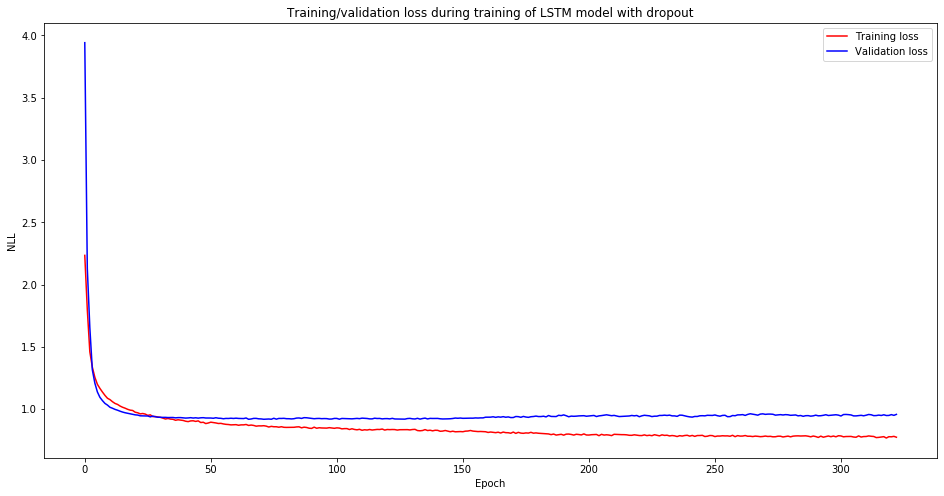

In [92]:
# Plot training and validation loss
epoch = np.arange(len(val_losses))
plt.figure(figsize=(16,8))
plt.plot(epoch, train_losses, 'r', label='Training loss',)
plt.plot(epoch, val_losses, 'b', label='Validation loss')
plt.legend()
plt.title("Training/validation loss during training of LSTM model with dropout")
plt.xlabel('Epoch'), plt.ylabel('NLL')

plt.savefig('/content/drive/My Drive/Colab Notebooks/training_validation loss during training of LSTM model with dropout.png')
plt.show()

Getting the lowest validation loss and calculating BPC.

In [93]:
def get_lowest_bpc(val_losses):
    return min(val_losses) / np.log(2)
    
get_lowest_bpc(val_losses)

1.3255738237554855

#### Training for unregularized model

In [94]:
model = CharModel(
    all_chars=weight_matrix.size(0),
    ninp = weight_matrix.size(1),
    num_hidden=1000,
    num_layers=3,
    weight_drop=0.5,
    batch_size = BATCH_SIZE,
    use_gpu=True,
    use_dropout = False,
)
print(model)

CharModel(
  (embedding): Embedding(52, 200)
  (lstm): LSTM(200, 1000, num_layers=3)
  (fc_linear): Linear(in_features=1000, out_features=52, bias=True)
)


In [95]:
# load and print model
import matplotlib.pyplot as plt
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_unregularized_100.pkl"
model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)

=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_unregularized_100.pkl'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_layed_lstm_unregularized_100.pkl' (epoch 100)


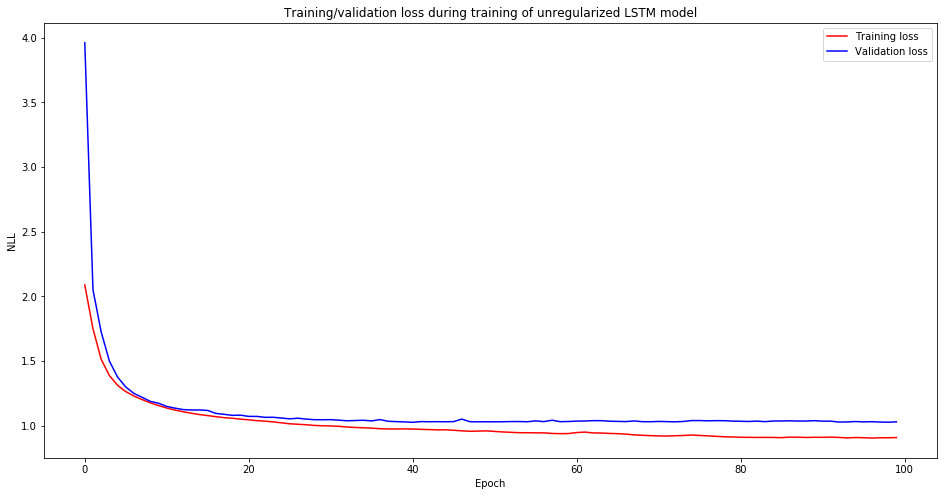

In [96]:
# Plot training and validation loss
epoch = np.arange(len(val_losses))
plt.figure(figsize=(16,8))
plt.plot(epoch, train_losses, 'r', label='Training loss',)
plt.plot(epoch, val_losses, 'b', label='Validation loss')
plt.legend()
plt.title("Training/validation loss during training of unregularized LSTM model")
plt.xlabel('Epoch'), plt.ylabel('NLL')

plt.savefig('/content/drive/My Drive/Colab Notebooks/training_validation loss during training of unregularized LSTM model.png')
plt.show()

Getting the lowest BPC.

In [97]:
get_lowest_bpc(val_losses)

1.4782328479326508